# "Classifiez automatiquement des biens de consommation"
_NLP Cleaning Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Mounting my Drive on Colab

In [1]:
from google.colab import files, output, drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


Installations and importations required in the virtual environment.

In [ ]:
# !pip install gtts
# !pip install wikipedia2vec==0.2.2
# !pip install category-encoders
# !pip install plotly>=4.0.0
# !pip install tensorflow-hub
# !pip install tensorflow==2.1.0

In [2]:
# Set the current working directory

import os
os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')

In [3]:
# Install requirements

!pip install -r requirements_nlp.txt
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt
# !wg-get install xvfb libgtk2.0-0 libgconf-2-4

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 276kB 5.6MB/s 
     |████████████████████████████████| 143kB 7.8MB/s 
     |████████████████████████████████| 3.9MB 5.8MB/s 
     |████████████████████████████████| 421.8MB 32kB/s 
     |████████████████████████████████| 450kB 55.4MB/s 
     |████████████████████████████████| 1.1MB 55.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=2a4e12f7e582483e2d929a6782f039d44bd7569b36aed9627eba94e51b42f256
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for marisa-trie: filename=marisa_trie-0.7.5-cp36-cp36m-linux_x86_64.whl size=861128 sha256=0bffeaf16f592a72099f88351c5d3414a603999d03fa3233e3cdea48efce853c
  Stored in directory: /root/.cache/pip/wheels/45/24/79/022624fc914f0e559fe8a1141aaff1f9df810905a13fc75d57
  Created wheel for mwparse

In [4]:
from P6_functions import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Installations (creating the requirements file)

In [ ]:
# !pip freeze > requirements_nlp.txt

Importation of modules and packages. 

In [5]:
import io
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Setting pandas display and matplotlib options.

In [6]:
# to show more cells while displaying pandas dataframe
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

# to set the figures background to white
plt.rcParams['figure.facecolor']='w'

To play audio text-to-speech during execution.

In [7]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

### 0.1 Importing the datasets

In this notebook we'll download only the text data, contained in a .csv file.

In [146]:
# Read from .csv file and store in a dataframe

df = pd.read_csv("../DATA/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

Data is composed of :
- one .csv file with descriptions and true categories
- one file of pictures

Let's import at first the descriptions, product names and categories and put it in a dataframe.

## 1 Data extraction

### 1.0 Data Overview

Size of the dataframe

In [9]:
df.shape

(1050, 14)

Names of the columns

In [10]:
df.columns

Index(['crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid',
       'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description',
       'product_rating', 'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

Description of the content

In [11]:
df.describe(include='all')

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1049.00,1049.00,1050,1050,1050,1050,1050,712,1049
unique,149,1050,1050,642,1050,nan,nan,1050,2,1050,27,27,490,984
top,2015-12-01 12:40:44 +0000,http://www.flipkart.com/sonata-8959yl01-yuva-gold-analog-watch-women/p/itmda5wawcyk9pby?pid=WATD...,Sassoon Cotton Bath Towel,"[""Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars""]",SHIE3FHYZYD3JHQD,nan,nan,e93cd13f5269dd51b8359ccf93ca5ace.jpg,False,Specifications of KDS SURGICAL Tripod Walking Stick In The Box 1 WALKING STICK General Brand KDS...,No rating available,No rating available,Lapguard,"{""product_specification""=>[{""key""=>""Type"", ""value""=>""Mug""}, {""key""=>""Mug Capacity"", ""value""=>""5...."
freq,150,1,1,56,1,nan,nan,1,993,1,889,889,11,22
mean,NaN,NaN,NaN,NaN,NaN,2186.20,1584.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,7639.23,7475.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,35.00,35.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,555.00,340.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,999.00,600.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1999.00,1199.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1 Categories

Unfolding categories using the 'product_category_tree' colum

In [12]:
# Sample checking

df['product_category_tree'][743]

'["Kitchen & Dining >> Containers & Bottles >> Bottles & Sippers >> Water bottle >> Nutcase Water bottle"]'

In [13]:
# Determining the maximum tree depth of categories

ser_depth = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max()
max_depth

6

In [14]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df.index)

In [15]:
# printing number of categories in each level and a sample
display(df_cat_level.nunique(), df_cat_level.sample(3))

cat_level_0      7
cat_level_1     62
cat_level_2    243
cat_level_3    460
cat_level_4    596
cat_level_5    633
dtype: int64

,cat_level_0,cat_level_1,cat_level_2,cat_level_3,cat_level_4,cat_level_5
uniq_id,,,,,,
cf3e938bf6d66c65ce94f8c206ed0809,Beauty and Personal Care,Beauty and Personal Care/Makeup,Beauty and Personal Care/Makeup/Eyes,Beauty and Personal Care/Makeup/Eyes/Eye Shadows,Beauty and Personal Care/Makeup/Eyes/Eye Shadows/e.l.f. Cosmetics Eye Shadows,Beauty and Personal Care/Makeup/Eyes/Eye Shadows/e.l.f. Cosmetics Eye Shadows/e.l.f. Cosmetics S...
f6fbce5fffb82a83d7529815c4be9a72,Beauty and Personal Care,Beauty and Personal Care/Fragrances,Beauty and Personal Care/Fragrances/Deodorants,Beauty and Personal Care/Fragrances/Deodorants/Combos,Beauty and Personal Care/Fragrances/Deodorants/Combos/Denver Combos,Beauty and Personal Care/Fragrances/Deodorants/Combos/Denver Combos/
9bd8526e99697998cdf7dcbdfa044847,Home Decor & Festive Needs,Home Decor & Festive Needs/Wall Decor & Clocks,Home Decor & Festive Needs/Wall Decor & Clocks/Wall Decals & Stickers,Home Decor & Festive Needs/Wall Decor & Clocks/Wall Decals & Stickers/Wall Decal Wall Decals & S...,Home Decor & Festive Needs/Wall Decor & Clocks/Wall Decals & Stickers/Wall Decal Wall Decals & S...,Home Decor & Festive Needs/Wall Decor & Clocks/Wall Decals & Stickers/Wall Decal Wall Decals & S...


Let's see how much items are in each category

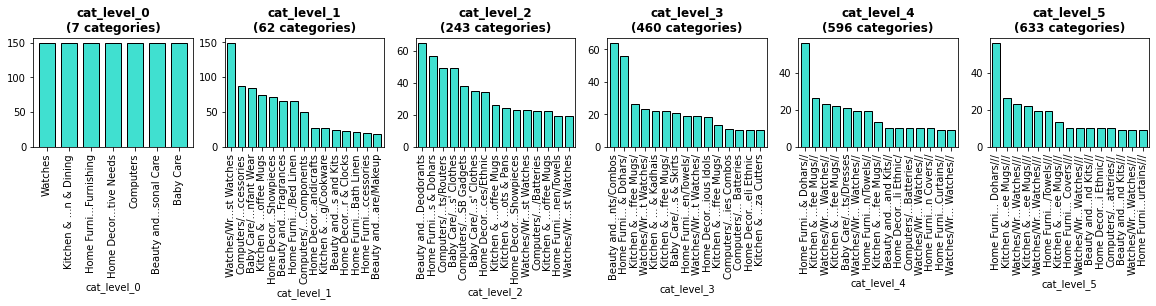

In [16]:
shorten_label = 10
n_first = 15
fig = plt.figure(figsize=(20,2))
for i, col in enumerate(df_cat_level.columns,1):
    # plot the graphs
    ax = fig.add_subplot(1,len(df_cat_level.columns), i)
    ser = df_cat_level.groupby(col).size().sort_values(ascending=False)
    ser[0:n_first].plot.bar(width=0.75, color='turquoise', ec='k', ax=ax)
    # shorten the labels
    thr = int(shorten_label)
    lab_x = [item.get_text() for item in ax.get_xticklabels()]
    short_lab_x = [s[:thr]+'...'+s[-thr:] if len(s)>thr else s for s in lab_x]
    ax.axes.set_xticklabels(short_lab_x)
    # set title
    ax.set_title(col+f'\n({ser.shape[0]} categories)', fontweight='bold')

The only level that has a balanced set of items is level 0, with 7 categories.
Let's rename these 7 categories:

In [17]:
df_cat_level['cat_level_0'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [18]:
df_cat_level['category'] = \
    df_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                         'Baby Care': 'Baby', 
                                         'Watches': 'Watches',
                                         'Home Decor & Festive Needs': 'Decor',
                                         'Kitchen & Dining': 'Kitchen',
                                         'Beauty and Personal Care': 'Beauty',
                                         'Computers': 'Computers'})

### 1.2 Products descriptions

In [19]:
# Extract only useful data

df_desc_cat = pd.concat([df_cat_level['category'],
                         df[["product_name", "description"]]], axis=1)

In [20]:
df_desc_cat.head(1)

,category,product_name,description
uniq_id,,,
55b85ea15a1536d46b7190ad6fff8ce7,Furnishing,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan..."


Have a look to one particular item

In [21]:
df_desc_cat.loc['762b6b22cccf91935e92446efe298fe3']['product_name']

"612 League Baby Boy's Checkered Casual Shirt"

In [22]:
df_desc_cat.loc['762b6b22cccf91935e92446efe298fe3']['description']

"Specifications of 612 League Baby Boy's Checkered Casual Shirt General Details Pattern Checkered Occasion Casual Ideal For Baby Boy's Shirt Details Sleeve Half Sleeve Number of Contents in Sales Package Pack of 1 Brand Fit Regular Fabric 100% COTTON Fit Regular Additional Details Style Code BLS00S380001B Fabric Care ENZYME WASH"

In [23]:
# creation of a corpus of all the descriptions
corpus = ' '.join(df_desc_cat['description'].values)
print("total nb of words in the whole corpus: ", len(corpus.split()))

total nb of words in the whole corpus:  80013


### 1.3 Global preprocessing

A first optimisation approach showed that some proprocessing steps are always beneficial to the models. We'll proceed to these steps before any further optimisation:
- lower case,
- keeping only alphabetic characters
- removing stopwords and single letters
- lemmatization
- keep only names and adjectives


In [24]:
# Stopwords and single letters
english_sw = nltk.corpus.stopwords.words('english')
single_let_sw = list(string.ascii_lowercase)
sw = list(set(english_sw + single_let_sw))

In [25]:
# Stemmer or lemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy

stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

These steps are embedded in the "tokenize_clean" function (see in "P6_functions.py" file)

In [26]:
#### Apply the transformations to descriptions and to product names

df_desc_cat['desc_clean'] = \
    df_desc_cat['description'].apply(lambda x: \
                                     tokenize_clean(x,
                                                    stopwords=sw,
                                                    keep_tags=['NN','JJ'],
                                                    stemmer=None,
                                                    lemmatizer=lemmatizer))\
                               .apply(lambda x: ' '.join(x))

df_desc_cat['pname_clean'] = \
    df_desc_cat['product_name'].apply(lambda x: \
                                     tokenize_clean(x,
                                                    stopwords=sw,
                                                    keep_tags=['NN','JJ'],
                                                    stemmer=None,
                                                    lemmatizer=lemmatizer))\
                              .apply(lambda x: ' '.join(x))

In [27]:
df_desc_cat.sample(3)

,category,product_name,description,desc_clean,pname_clean
uniq_id,,,,,
987e13b445c34bfedb9796d2bb78d593,Watches,Maxima 01727LPLN Mac Gold Analog Watch - For Women,Maxima 01727LPLN Mac Gold Analog Watch - For Women - Buy Maxima 01727LPLN Mac Gold Analog Watch...,maxima lpln mac gold analog watch maxima lpln mac gold analog watch lpln online rs india flipkar...,maxima lpln mac gold analog watch
08e8af585235d7403ca2b7b56a51a6d4,Furnishing,Onlinemaniya Abstract Single Quilts & Comforters Multicolor,Buy Onlinemaniya Abstract Single Quilts & Comforters Multicolor at Rs. 790 at Flipkart.com. Only...,onlinemaniya abstract single rs flipkart com genuine free cash delivery,onlinemaniya abstract single
964648862f322b2cc153239af04b22ef,Computers,ARB Toshiba Dynabook SS MX/395LS Compatible Black 6 Cell Laptop Battery,Buy ARB Toshiba Dynabook SS MX/395LS Compatible Black 6 Cell Laptop Battery only for Rs. 1599 fr...,arb toshiba dynabook ss mx ls compatible black cell battery rs flipkart com genuine day replacem...,arb ss mx compatible black cell laptop battery


## 2 Exploratory Data Analysis

### 2.1 Most frequent words

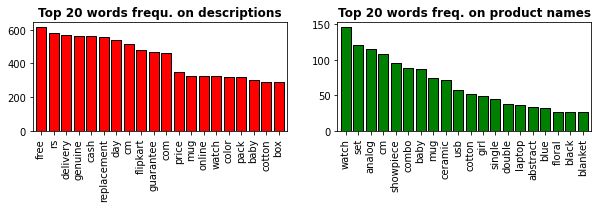

In [81]:
# creation of a corpus of all the cleaned descriptions and product_names
corpus_desc = ' '.join(df_desc_cat['desc_clean'].values)
corpus_pname = ' '.join(df_desc_cat['pname_clean'].values)
# tokenizing the words in the cleaned corpus
tokenizer = nltk.RegexpTokenizer(r'[a-z]+')
li_words_desc = tokenizer.tokenize(corpus_desc.lower())
li_words_pname = tokenizer.tokenize(corpus_pname.lower())
# counting frequency of each word
ser_freq_desc = pd.Series(nltk.FreqDist(li_words_desc))
ser_freq_pname = pd.Series(nltk.FreqDist(li_words_pname))

fig = plt.figure(figsize=(10,2))
# plotting the most frequent words
ax = fig.add_subplot(1,2,1)
ser_freq_desc.sort_values(ascending=False)[0:20].plot.bar(width=0.8,
                                                          color='red',
                                                          ec='k',
                                                          ax=ax)
ax.set_title("Top 20 words frequ. on descriptions", fontweight='bold')
ax = fig.add_subplot(1,2,2)
ser_freq_pname.sort_values(ascending=False)[0:20].plot.bar(width=0.8,
                                                           color='green',
                                                           ec='k',
                                                           ax=ax)
ax.set_title("Top 20 words freq. on product names", fontweight='bold')
plt.show()

### 2.2 Wordclouds by categories

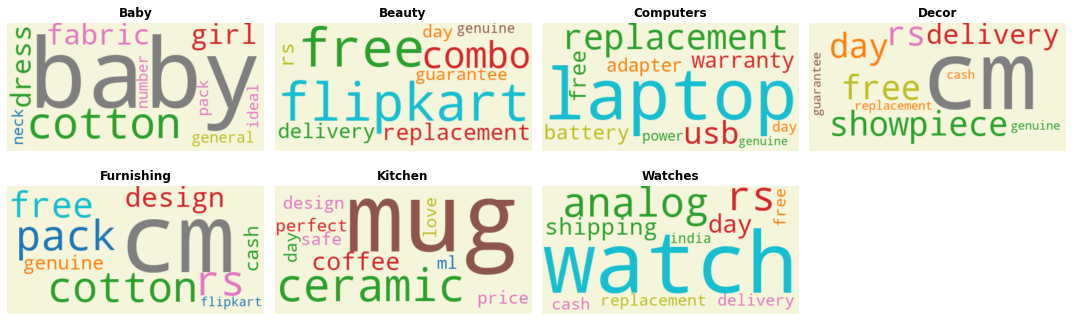

In [76]:
gb = df_desc_cat.groupby('category')['desc_clean']

plot_wordclouds_from_gb(gb, n_top_words=10, n_rows=2, figsize=(15,5),
                        backgnd_color='beige', cmap='tab10', random_state=14)

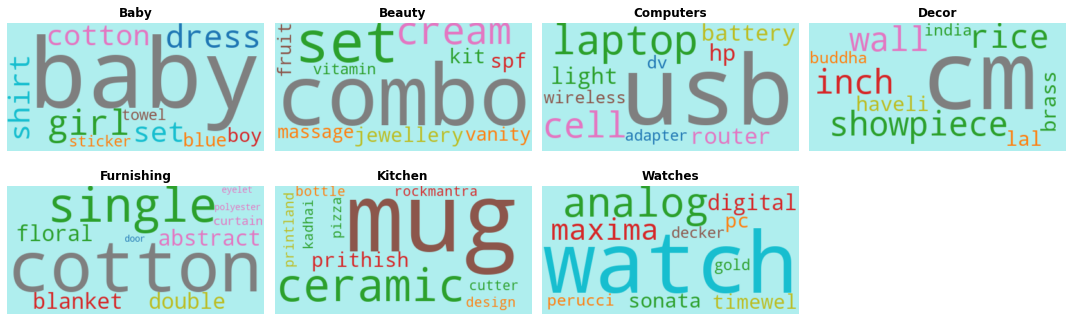

In [69]:
gb = df_desc_cat.groupby('category')['pname_clean']

plot_wordclouds_from_gb(gb, n_top_words=10, n_rows=2, figsize=(15,5),
                        backgnd_color='paleturquoise', cmap='tab10', random_state=14)

Let's try to compare the most frequent words in the descriptions and in the product names : we plot the frequency of the description top words vs frequency of the product name top words and vice versa. 

In [77]:
# Put the frequencies of words in descriptions and prooduct names in 1 dataframe
df_freq = pd.concat([ser_freq_desc.to_frame(name='desc'),
                     ser_freq_pname.to_frame(name='pname')],
                    axis=1).fillna(0)

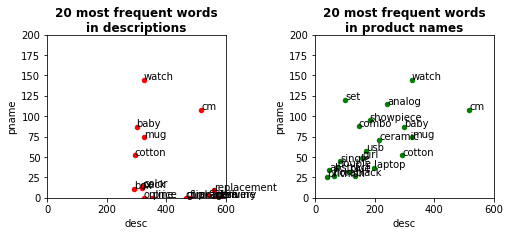

In [83]:
### Plot a comparative scatter plot of the frequencies of the top words 

n_most_freq = 20
fig = plt.figure(figsize=(8,3))

# Left : Most frequent words in the descriptions
ax1 = fig.add_subplot(1,2,1)
df1 = df_freq.sort_values('desc',
                    ascending=False).iloc[:n_most_freq]
df1.plot.scatter(x='desc', y='pname', color='red', ax=ax1)
ax1.set(xlim=(0,600), ylim=(0,200))

for i, txt in enumerate(list(df1.index)):
    ax1.annotate(txt, (df1['desc'].iloc[i],
                       df1['pname'].iloc[i]))
ax1.set_title(f'{n_most_freq} most frequent words\nin descriptions',
              fontweight='bold', pad=0.2)

# Right : Most frequent words in the product names
ax2 = fig.add_subplot(1,2,2)
df2 = df_freq.sort_values('pname',
                    ascending=False).iloc[:n_most_freq]
df2.plot.scatter(x='desc', y='pname', color='green', ax=ax2)
ax2.set(xlim=(0,600), ylim=(0,200))

for i, txt in enumerate(list(df2.index)):
    ax2.annotate(txt, (df2['desc'].iloc[i],
                      df2['pname'].iloc[i]))
ax2.set_title(f'{n_most_freq} most frequent words\nin product names',
              fontweight='bold', pad=0.2)

plt.subplots_adjust(wspace=0.5)
plt.show()

## 4 GridSearch optimization

#### Road map

We want to optimise the matching between the given categories ("true categories") and the clusters labels that can be found with unsupervised ML models.

The optimisation of the matching will be made using the v_measure metric using a custom GridSearch (GridSearchClust class in "P6_functions.py") adapted for clustering.

Various approaches will be tried for preprocessing and clustering:
- KMeans clustering of a simple document-terms matrix,
- Kmeans clustering of a document-term matrix (with dimensionality reduction prior to clustering)
- Main topic (*argmax()*) obtained by topics modelisation (LSA, NMF, LDA)
- Kmeans clustering on a matrix obtained using word or sentence embeddings technique

#### Metrics choice for optimization

The metrics we'll use for optimisation is v_measure defined as:

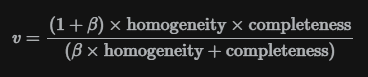

Where homogeneity and completeness are respectively:

Homogeneity and completeness scores are formally given by:

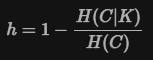 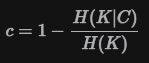

where  is the conditional entropy of the classes given the cluster assignments and is given by:

 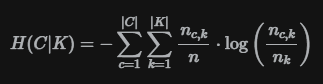
 
 
 
and  is the entropy of the classes and is given by:

 
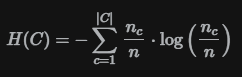 
 
with  the total number of samples, 
 and 
 the number of samples respectively belonging to class  and cluster , and finally  the number of samples from class  assigned to cluster .
 

**Bounded scores**: 0.0 is as bad as it can be, 1.0 is a perfect score.

**Intuitive interpretation**: clustering with bad V-measure can be qualitatively analyzed in terms of homogeneity and completeness to better feel what ‘kind’ of mistakes is done by the assignment.

**No assumption is made on the cluster structure**: can be used to compare clustering algorithms such as k-means which assumes isotropic blob shapes with results of spectral clustering algorithms which can find cluster with “folded” shapes.

**Drawbacks**:

- The previously introduced metrics are not normalized with regards to random labeling: this means that depending on the number of samples, clusters and ground truth classes, a completely random labeling will not always yield the same values for homogeneity, completeness and hence v-measure. In particular random labeling won’t yield zero scores especially when the number of clusters is large.

- This problem can safely be ignored when the number of samples is more than a thousand and the number of clusters is less than 10. For smaller sample sizes or larger number of clusters it is safer to use an adjusted index such as the Adjusted Rand Index (ARI).

Importations

In [84]:
import copy
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
from nltk.stem.snowball import EnglishStemmer
import spacy

In [85]:
df_res_clust = pd.DataFrame()
df_res_clust['categories'] = df_desc_cat['category']

In [86]:
dict_best_df = {}

### 4.1 Optimize preprocessing (document-terms matrix) -> KMeans clustering

At first we'll try to find the simple document-terms matrix encoding that gives the best KMeans score.

The pipeline to be optimized has 2 steps:
- Custom NLP transformer (BOW or TFIDF matrix) with various options (binary, max_features, min_df, max_df etc.)
- KMeans clustering (7 categories)

In [87]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('clusterer', KMeans(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__min_df': [0, 0.05, 0.1],
              'custtrans__max_df': [0.13, 0.15, 1.0],
              'custtrans__max_features': [300,400,500,550,600,650,700,800,900],
              'custtrans__ngram_range': [(1,1), (1,2), (1,3)],
              'custtrans__binary': [False, True],
              'custtrans__tfidf_on': [False, True],
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.5, 0.6, 0.625, 0.65, 0.675, 0.7],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

In [ ]:
# ##### Perform the grid search
# gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']],
#         verbose=True);

In [ ]:
# ### Pickling the results
# import dill as pickle
# with open('N01_gsc_preproc_km.pkl', 'wb') as file:
#     pickle.dump(gsc, file)

In [89]:
### Loading the results
import dill as pickle
with open('N01_gsc_preproc_km.pkl', 'rb') as file:
    gsc = pickle.load(file)

In [ ]:
# Display results

print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
# Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True,
# 'custtrans__max_df': 0.15, 'custtrans__max_features': 500,
# 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1),
# 'custtrans__pname_weight': 0.6, 'custtrans__tfidf_on': False,
# 'custtrans__w2v': None}
# Best refit score: 0.4019957322565853

Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__max_df': 0.15, 'custtrans__max_features': 500, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.6, 'custtrans__tfidf_on': False, 'custtrans__w2v': None}
Best refit score: 0.4019957322565853


Plotting the results of the clustering optimization

In [91]:
# Compute the dataframe showing the results depending on one parameter
# (other parameters set tot best_params_)

filters_gsc_results(gsc, 'custtrans__pname_weight', n_score='ari')

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
custtrans__pname_weight,,,,,,,,
0.50,0.09,40.86,2.74,0.48,0.27,0.44,0.54,0.48
0.60,0.11,46.61,3.12,0.57,0.40,0.55,0.59,0.57
0.62,0.11,42.31,2.94,0.49,0.30,0.47,0.54,0.50
0.65,0.11,45.85,2.24,0.54,0.24,0.47,0.67,0.55
0.68,0.07,42.77,2.28,0.53,0.22,0.45,0.65,0.53
0.70,0.07,42.93,2.27,0.53,0.22,0.45,0.66,0.53


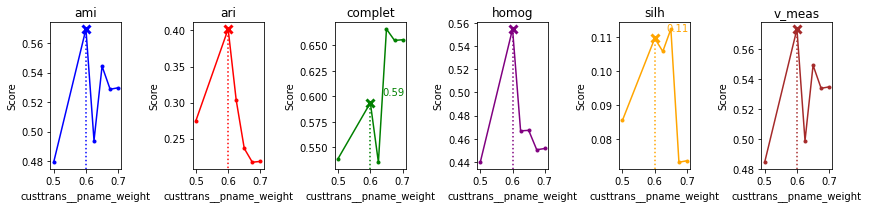

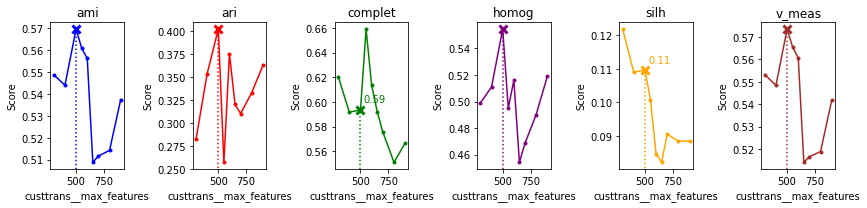

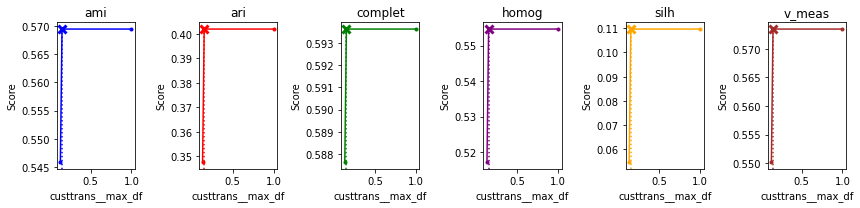

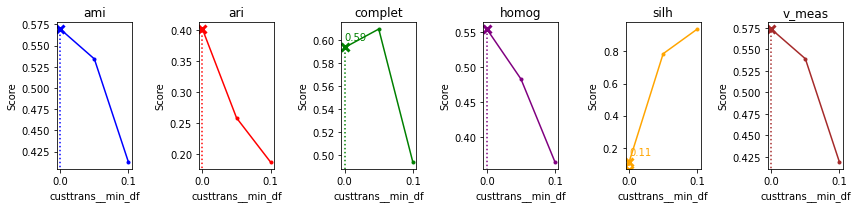

In [92]:
# Plotting the graphs of the clustering scores with best refit score (line)

optim_score = 'ari'

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_df', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__min_df', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



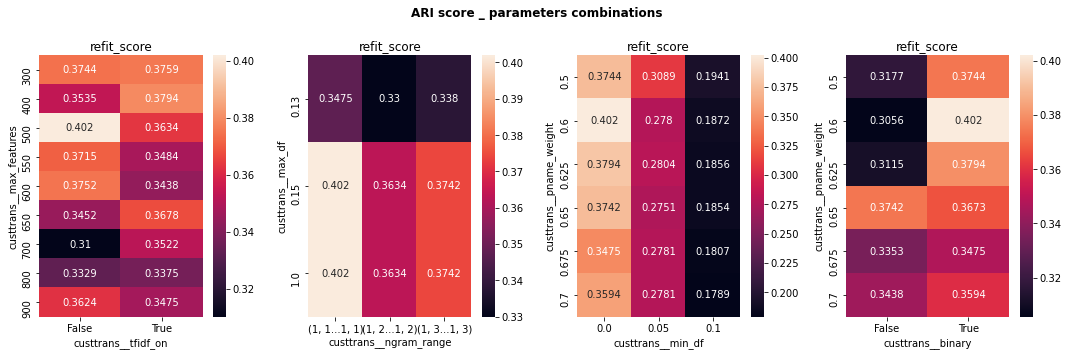

In [95]:
# Effect of 2 parameters on clustering scores

params1 = ['custtrans__max_features', 'custtrans__tfidf_on']
params2 = ['custtrans__max_df', 'custtrans__ngram_range']
params3 = ['custtrans__pname_weight', 'custtrans__min_df']
params4 = ['custtrans__pname_weight', 'custtrans__binary']

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,4,1)
plot_2D_gsclust_param_opt(gsc, params=params1, shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,4,2)
plot_2D_gsclust_param_opt(gsc, params=params2, shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,4,3)
plot_2D_gsclust_param_opt(gsc, params=params3, shorten_label=5, ax=ax3)

ax4 = fig.add_subplot(1,4,4)
plot_2D_gsclust_param_opt(gsc, params=params4, shorten_label=5, ax=ax4)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



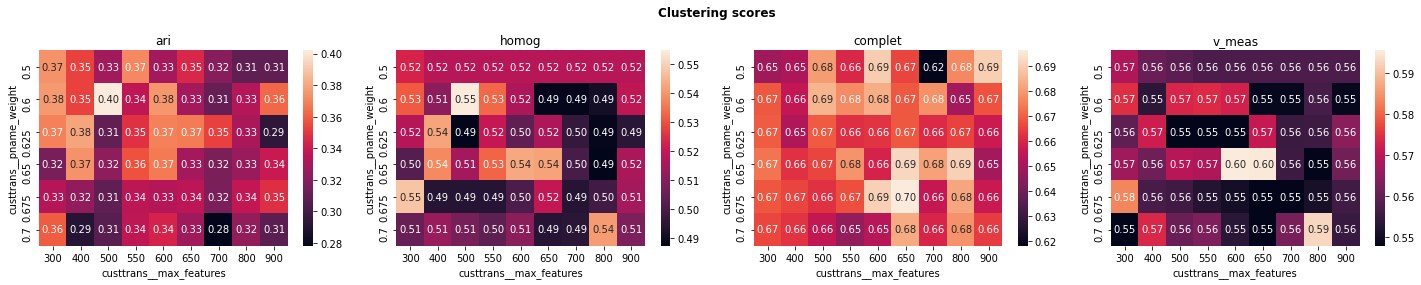

In [94]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['custtrans__pname_weight', 'custtrans__max_features']

scores = ['ari', 'homog', 'complet', 'v_meas']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [102]:
# Computing the best preprocessed dataset prior to clustering

dict_best_df['N01_gsc_preproc_km-ARI'] = \
                gsc.transform(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='ari')
dict_best_df['N01_gsc_preproc_km-VMEAS'] = \
                gsc.transform(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='v_meas')

In [103]:
# Storing labels of the best model in a dataframe

df_res_clust['N01_gsc_preproc_km-ARI'] = \
                gsc.predict(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='ari')
df_res_clust['N01_gsc_preproc_km-VMEAS'] = \
                gsc.predict(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='v_meas')

### 4.2 Optimize preprocessing (dimension reduction) -> KMeans clustering

Let's see if a dimensionality reduction over a document-terms matrix can give better KMeans score.

The pipeline to be optimized has 3 steps:
- Custom NLP transformer (BOW or TFIDF matrix) with various options (binary, max_features, min_df, max_df etc.)
- Dimensionality reduction
- KMeans clustering (7 categories)

In [104]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('dimreduc', PCA()), # Dimensionality reduction 
                 ('clusterer', KMeans(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__min_df': [0],
              'custtrans__max_df': [1.0],
              'custtrans__max_features': [100,200,250,300,
                                          500,900],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [False, True],
              'custtrans__tfidf_on': [False, True],
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.4,0.6,0.65,0.7,0.9],
              'dimreduc': [
                           PCA(random_state=14), 
                           LDA(random_state=14),
                           NMF(random_state=14),
                           TruncatedSVD(random_state=14),
                           ], #[TSNE_wrapper(random_state=14), UMAP(random_state=14)],
              'dimreduc__n_components': [2,5,7,10,20,50,99],
            #   'svd__n_iter': [4,5,6],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

In [ ]:
# ##### Perform the grid search
# gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);

In [ ]:
# ### Pickling the results
# import dill as pickle
# with open('N02_gsc_preproc_dimred_km.pkl', 'wb') as file:
#     pickle.dump(gsc, file)

In [105]:
### Loading the results
import dill as pickle
with open('N02_gsc_preproc_dimred_km.pkl', 'rb') as file:
    gsc = pickle.load(file)

In [106]:
# Display results

print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
# -----Product name
# Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': False, 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None, 'custtrans__max_df': 1.0, 'custtrans__max_features': 300, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.65, 'custtrans__stemmer': None, 'custtrans__stopwords': None, 'custtrans__tfidf_on': False, 'custtrans__w2v': None, 'dimreduc': LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
#                           evaluate_every=-1, learning_decay=0.7,
#                           learning_method='batch', learning_offset=10.0,
#                           max_doc_update_iter=100, max_iter=10,
#                           mean_change_tol=0.001, n_components=100, n_jobs=None,
#                           perp_tol=0.1, random_state=14, topic_word_prior=None,
#                           total_samples=1000000.0, verbose=0), 'dimreduc__n_components': 10}
# Best refit score: 0.4689158879407379

Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': False, 'custtrans__max_df': 1.0, 'custtrans__max_features': 300, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.65, 'custtrans__tfidf_on': False, 'custtrans__w2v': None, 'dimreduc': LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=99, n_jobs=None,
                          perp_tol=0.1, random_state=14, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0), 'dimreduc__n_components': 10}
Best refit score: 0.4689158879407379


Plotting the results of the clustering optimization

In [107]:
# Compute the dataframe showing the results depending on one parameter
# (other parameters set tot best_params_)

filters_gsc_results(gsc, 'custtrans__pname_weight', n_score='ari')

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
custtrans__pname_weight,,,,,,,,
0.40,0.54,427.41,1.03,0.52,0.41,0.51,0.53,0.52
0.60,0.54,406.66,1.06,0.50,0.40,0.49,0.51,0.50
0.65,0.54,385.51,1.14,0.53,0.47,0.53,0.54,0.53
0.70,0.55,407.29,0.99,0.47,0.36,0.46,0.49,0.48
0.90,0.54,373.39,1.06,0.44,0.38,0.44,0.46,0.45


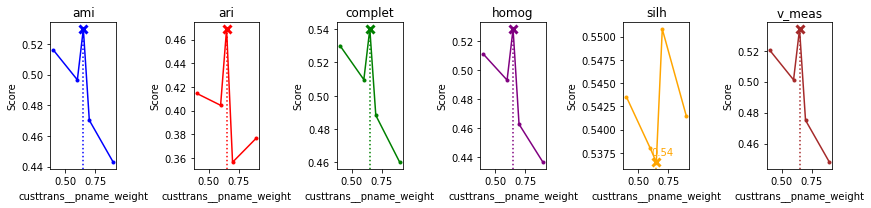

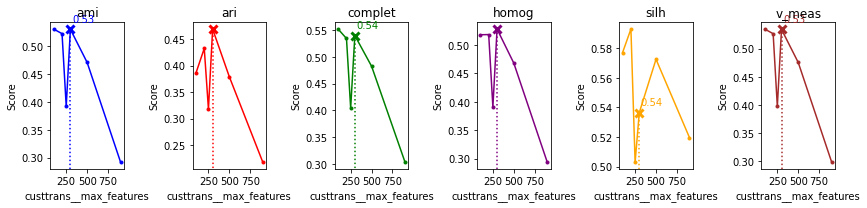

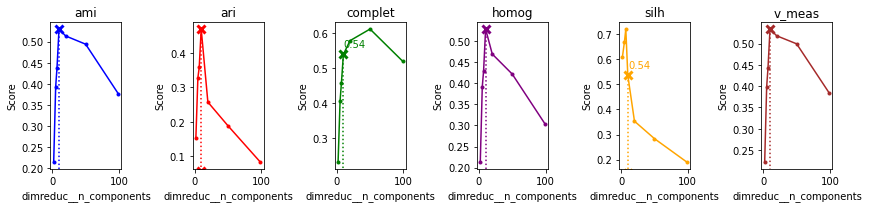

In [108]:
# Plotting the graphs of the clustering scores with best refit score (line)

optim_score = 'ari'

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc, param='dimreduc__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



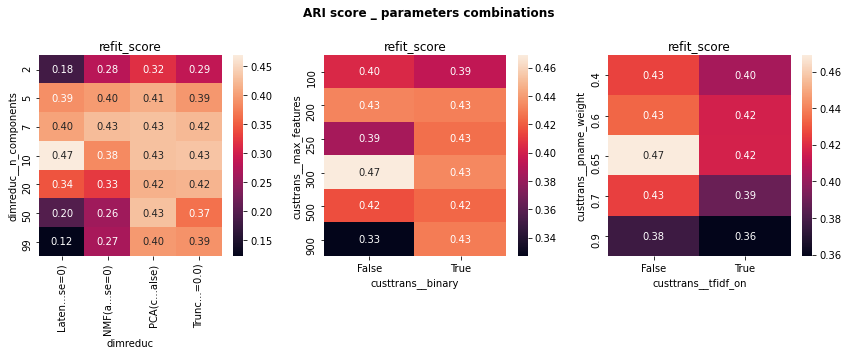

In [109]:
# Effect of 2 parameters on clustering scores

params1 = ['dimreduc__n_components', 'dimreduc']
params2 = ['custtrans__max_features', 'custtrans__binary']
params3 = ['custtrans__pname_weight', 'custtrans__tfidf_on']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, fmt='.2f',
                          shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, fmt='.2f',
                          shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, fmt='.2f',
                          shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



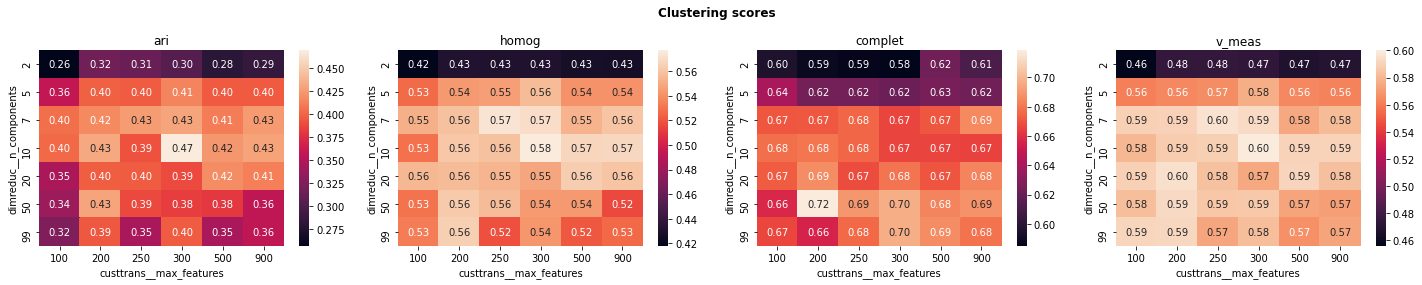

In [110]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['dimreduc__n_components', 'custtrans__max_features']

scores = ['ari', 'homog', 'complet', 'v_meas']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [ ]:
# Computing the best preprocessed dataset prior to clustering

dict_best_df['N02_preproc_dimred_km-ARI'] = \
                gsc.transform(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='v_meas')
dict_best_df['N02_preproc_dimred_km-VMEAS'] = \
                gsc.transform(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='ari')

In [ ]:
# Storing labels of the best model in a dataframe

df_res_clust['N02_preproc_dimred_km-ARI'] = \
                gsc.predict(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='ari')
df_res_clust['N02_preproc_dimred_km-VMEAS'] = \
                gsc.predict(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='v_meas')

### 4.3 Optimize preprocessing and choice of topics modelers

In [ ]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([
                 ('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('clusterer', TopicsModeler(random_state=14))
                 ]) # Topics modeler

# Define the list of params to be tested in the GridSearchClust
param_grid = {
              'custtrans__min_df': [0], # [0,0.01, 0.02]
              'custtrans__max_df': [1.0], #[0.1,0.15,0.2,0.3]
              'custtrans__max_features': [20,50,100,125,128,130,135,150,200,
                                          300,400,500,1000,1500,2000],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [True, False], # False
              'custtrans__tfidf_on': [True, False], # False
              'custtrans__w2v': [None],
              'custtrans__pname_weight': [0.4,0.6,0.7,0.8,0.9,0.94,0.93,
                                          0.94,0.95,0.98,1.0],
              'clusterer__n_model': ['nmf', 'lda', 'lsa'],
              'clusterer__n_components': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True) # for the refit_score

In [ ]:
# ##### Perform the grid search
# gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);

In [ ]:
# ### Pickling the results
# import dill as pickle
# with open('N03_gsc_preproc_tm.pkl', 'wb') as file:
#     pickle.dump(gsc, file)

In [112]:
### Loading the results
import dill as pickle
with open('N03_gsc_preproc_tm.pkl', 'rb') as file:
    gsc = pickle.load(file)

In [113]:
# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)

# -----Product name
# Best hyperparameters: {'clusterer__n_components': 7,
# 'clusterer__n_model': 'lsa', 'custtrans__binary': True,
# 'custtrans__keep_tags': None, 'custtrans__lemmatizer': None,
# 'custtrans__max_df': 1.0, 'custtrans__max_features': 128,
# 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1),
# 'custtrans__pname_weight': 0.95, 'custtrans__stemmer': None,
# 'custtrans__stopwords': None, 'custtrans__tfidf_on': True,
# 'custtrans__w2v': None}
# Best refit score: 0.5589243257333256

-----Product name
Best hyperparameters: {'clusterer__n_components': 7, 'clusterer__n_model': 'lsa', 'custtrans__binary': True, 'custtrans__max_df': 1.0, 'custtrans__max_features': 128, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.95, 'custtrans__tfidf_on': True, 'custtrans__w2v': None}
Best refit score: 0.5589243257333256


Plotting the results of the clustering optimization

In [114]:
# Compute the dataframe showing the results depending on one parameter
# (other parameters set tot best_params_)

filters_gsc_results(gsc, 'custtrans__pname_weight', n_score='ari')

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
custtrans__pname_weight,,,,,,,,
0.40,0.06,32.50,3.13,0.29,0.15,0.25,0.36,0.29
0.60,0.10,41.39,3.00,0.45,0.36,0.44,0.48,0.46
0.70,0.13,51.33,3.01,0.53,0.51,0.53,0.54,0.54
0.80,0.14,52.78,3.04,0.56,0.53,0.56,0.57,0.57
0.90,0.13,51.78,3.14,0.57,0.54,0.57,0.58,0.57
0.94,0.13,51.65,3.18,0.58,0.55,0.58,0.59,0.58
0.93,0.13,51.85,3.18,0.58,0.55,0.58,0.59,0.58
0.94,0.13,51.65,3.18,0.58,0.55,0.58,0.59,0.58
0.95,0.13,51.16,3.18,0.59,0.56,0.59,0.60,0.59


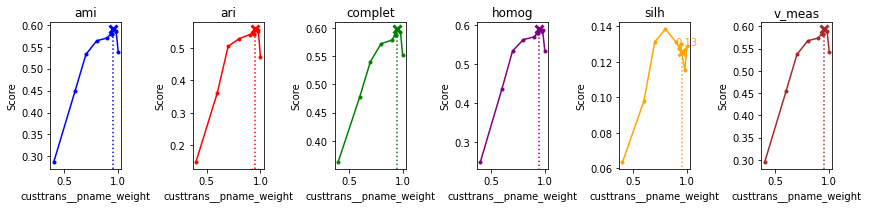

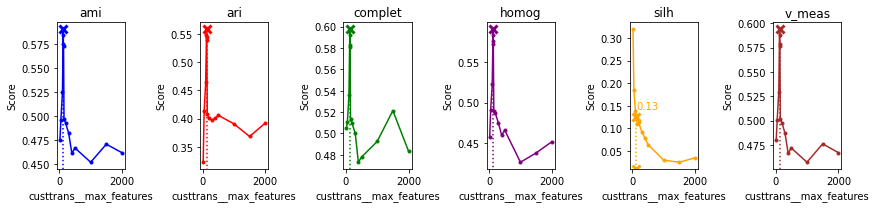

In [115]:
# Plotting the graphs of the clustering scores with best refit score (line)

optim_score = 'ari'

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



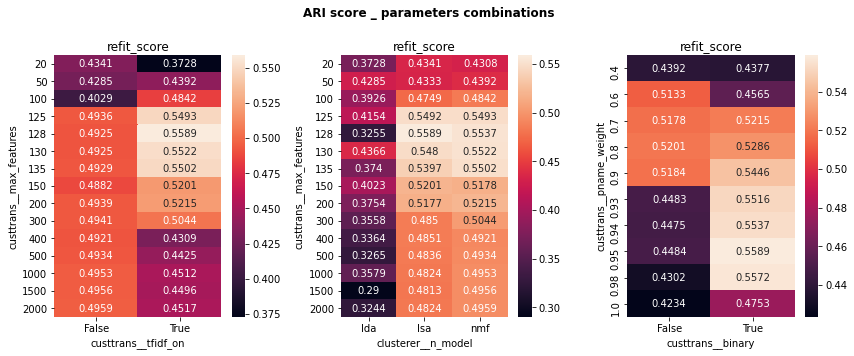

In [116]:
# Effect of 2 parameters on clustering scores

params1 = ['custtrans__max_features', 'custtrans__tfidf_on']
params2 = ['custtrans__max_features', 'clusterer__n_model']
params3 = ['custtrans__pname_weight', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, shorten_label=5, ax=ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, shorten_label=5, ax=ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



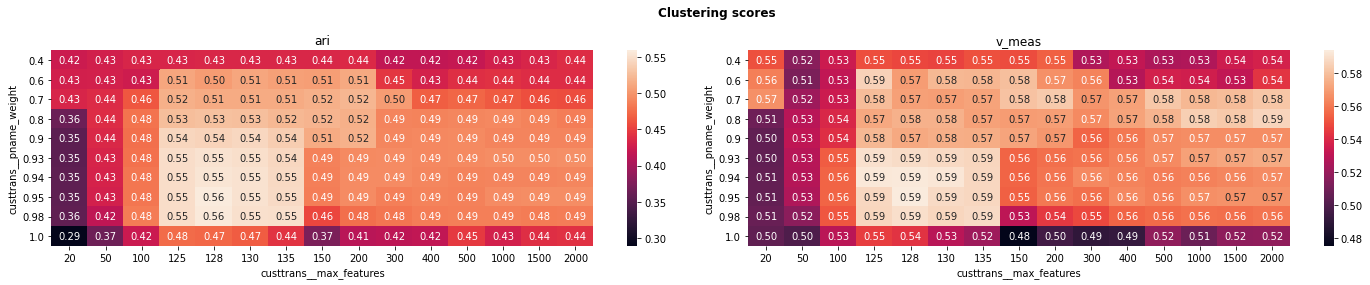

In [117]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['custtrans__pname_weight', 'custtrans__max_features']

scores = ['ari', 'v_meas'] # list(gsc.get_params()['scoring'])
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [ ]:
# Computing the best preprocessed dataset prior to clustering

dict_best_df['N03_gsc_preproc_tm-ARI'] = \
                gsc.transform(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='v_meas')
dict_best_df['N03_gsc_preproc_tm-VMEAS'] = \
                gsc.transform(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='ari')

In [ ]:
# Storing labels of the best model in a dataframe

df_res_clust['N03_gsc_preproc_tm-ARI'] = \
                gsc.predict(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='ari')
df_res_clust['N03_gsc_preproc_tm-VMEAS'] = \
                gsc.predict(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                            optim_score='v_meas')

### 4.4 Optimize preprocessing (pretrained word embeddings)

Optimisation using a custom GridSearch adapted for clustering.

Using either 'descriptions' or 'product_name'

The pipeline to be optimized has 2 steps:
- Custom NLP transformer (BOW or TFIDF matrix)
- Clustering using topics modeling (7 topics)

#### Wiki2vec

In [ ]:
## Using a pretrained model
# download the model from the internet
# https://wikipedia2vec.github.io/wikipedia2vec/pretrained/
cwd = os.getcwd()
os.chdir('/content')
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
# unzip the wiki2vec data
!bzip2 -d enwiki_20180420_100d.pkl.bz2

--2020-11-16 20:38:50--  http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
Resolving wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)... 52.219.1.105
Connecting to wikipedia2vec.s3.amazonaws.com (wikipedia2vec.s3.amazonaws.com)|52.219.1.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3514838671 (3.3G) [application/x-bzip2]
Saving to: ‘enwiki_20180420_100d.pkl.bz2’

enwiki_20180420_100 100%[===================>]   3.27G  13.4MB/s    in 4m 20s  

2020-11-16 20:43:10 (12.9 MB/s) - ‘enwiki_20180420_100d.pkl.bz2’ saved [3514838671/3514838671]



In [ ]:
# load the data in the notebook
from wikipedia2vec import Wikipedia2Vec

wiki2vec = Wikipedia2Vec.load("enwiki_20180420_100d.pkl") # 100 dimensions
os.chdir(cwd)

In [ ]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([
                 ('custtrans', CustNLPTransformer(path_wiki2vec="/content")), # Custom NLP preprocessor
                 ('dimreduc', PCA(random_state=14)),
                 ('clusterer', KMeans(random_state=14)), #TopicsModeler(random_state=14))
                 ]) # Topics modeler

# Define the list of params to be tested in the GridSearchClust
param_grid = [
              {
              'custtrans__min_df': [0],
              'custtrans__max_df': [1.0],
              'custtrans__max_features': [51,70,100,200,500],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [True, False], # False
              'custtrans__tfidf_on': [True, False], # False
              'custtrans__w2v': [True],
              'custtrans__pname_weight': [0.5,0.6,0.7,0.8,0.9],
              'dimreduc': [PCA(random_state=14), 
                           UMAP(random_state=14),
                           TruncatedSVD(random_state=14)],
              'dimreduc__n_components': [2,5,10,20,50],
              'clusterer__n_clusters': [7]
                },
              {
              'custtrans__min_df': [0],
              'custtrans__max_df': [1.0],
              'custtrans__max_features': [70,150,200,250,300,500],
              'custtrans__ngram_range': [(1,1)],
              'custtrans__binary': [True, False], # False
              'custtrans__tfidf_on': [True, False], # False
              'custtrans__w2v': [True],
              'custtrans__pname_weight': [0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              'dimreduc': [TSNE_wrapper(random_state=14)],
              'dimreduc__n_components': [2,3],
              'dimreduc__method': ['barnes_hut'],
              'dimreduc__perplexity': [1,5,10,20,50],
              'clusterer__n_clusters': [7]
                }]

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True,
                      return_estimators=True)

In [ ]:
# ##### Perform the grid search
# gsc.fit(df_desc_cat[['desc_clean', 'pname_clean']], verbose=True);#1294

In [ ]:
# ### Pickling the results
# import dill as pickle
# with open('N04a_gsc_preproc_dimreduc_w2v_km.pkl', 'wb') as file:
#     pickle.dump(gsc, file)

In [118]:
### Loading the results
import dill as pickle
with open('N04a_gsc_preproc_dimreduc_w2v_km.pkl', 'rb') as file:
    gsc = pickle.load(file)

In [119]:
# Display results (products name)
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_
# Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True,
# 'custtrans__max_df': 1.0, 'custtrans__max_features': 250, 'custtrans__min_df': 0,
# 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.5,
# 'custtrans__tfidf_on': True, 'custtrans__w2v': True,
# 'dimreduc': TSNE_wrapper(angle=0.5, early_exaggeration=12.0, init='random',
#              learning_rate=200.0, method='barnes_hut', metric='euclidean',
#              min_grad_norm=1e-07, n_components=3, n_iter=1000,
#              n_iter_without_progress=300, n_jobs=None, perplexity=50,
#              random_state=14, verbose=0), 'dimreduc__method': 'barnes_hut',
# 'dimreduc__n_components': 3, 'dimreduc__perplexity': 20}
# Best refit score: 0.5564894035909392

Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__max_df': 1.0, 'custtrans__max_features': 250, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__pname_weight': 0.5, 'custtrans__tfidf_on': True, 'custtrans__w2v': True, 'dimreduc': TSNE_wrapper(angle=0.5, early_exaggeration=12.0, init='random',
             learning_rate=200.0, method='barnes_hut', metric='euclidean',
             min_grad_norm=1e-07, n_components=3, n_iter=1000,
             n_iter_without_progress=300, n_jobs=None, perplexity=50,
             random_state=14, verbose=0), 'dimreduc__method': 'barnes_hut', 'dimreduc__n_components': 3, 'dimreduc__perplexity': 20}
Best refit score: 0.5564894035909392


Plotting the results of the clustering optimization

In [120]:
filters_gsc_results(gsc, 'custtrans__max_features', n_score='silh')

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
custtrans__max_features,,,,,,,,
51,0.75,1947.67,0.50,0.42,0.18,0.38,0.49,0.43
70,0.78,3032.73,0.27,0.43,0.19,0.38,0.51,0.43
100,0.54,2381.68,0.67,0.45,0.24,0.40,0.51,0.45
200,0.61,2121.95,0.45,0.45,0.17,0.37,0.59,0.45
500,0.51,2179.73,0.54,0.50,0.33,0.46,0.57,0.51


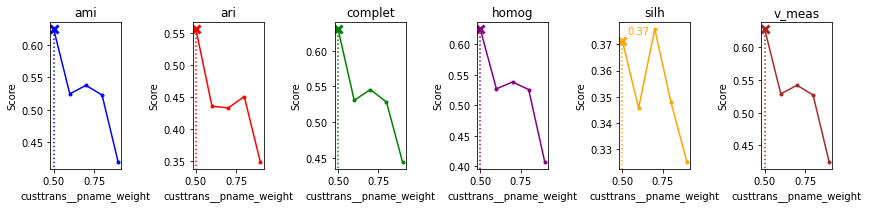

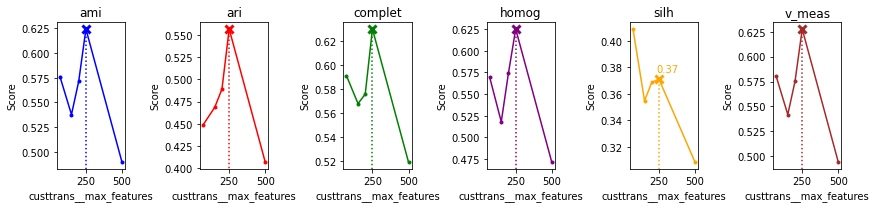

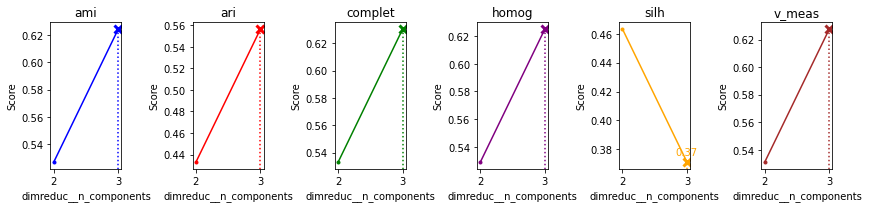

In [121]:
# Plotting the graphs of the clustering scores with best refit score (line)

optim_score = 'ari'

plot_gsc_multi_scores(gsc=gsc, param='custtrans__pname_weight', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc, param='custtrans__max_features', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc, param='dimreduc__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



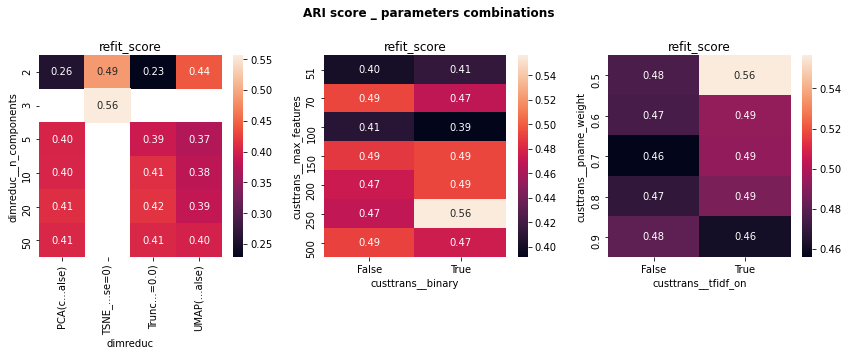

In [122]:
# Effect of 2 parameters on clustering scores

params1 = ['dimreduc__n_components', 'dimreduc']
params2 = ['custtrans__max_features', 'custtrans__binary']
params3 = ['custtrans__pname_weight', 'custtrans__tfidf_on']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc, params=params1, fmt='.2f',
                          shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc, params=params2, fmt='.2f',
                          shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc, params=params3, fmt='.2f',
                          shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



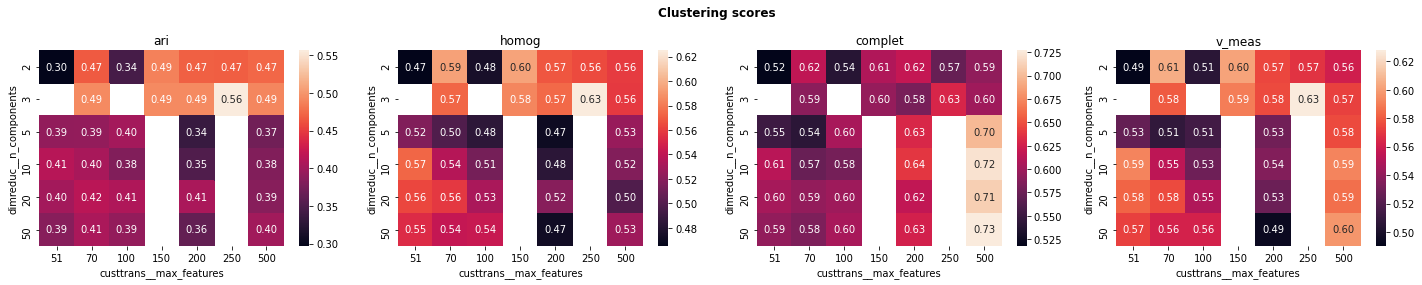

In [123]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,4))
params = ['dimreduc__n_components', 'custtrans__max_features']

scores = ['ari', 'homog', 'complet', 'v_meas']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [ ]:
# Computing the best preprocessed dataset prior to clustering

dict_best_df['N04a_gsc_preproc_dimreduc_w2v_km-ARI'] = \
                gsc.transform(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                              optim_score='v_meas')
dict_best_df['N04a_gsc_preproc_dimreduc_w2v_km-VMEAS'] = \
                gsc.transform(df_desc_cat[['desc_clean',
                                        'pname_clean']],
                              optim_score='ari')

In [ ]:
# Storing labels of the best model in a dataframe

#### A REPARER : POURQUOI GSC.PREDICT NE MARCHE PAS ?
# df_res_clust['N04a_gsc_preproc_dimreduc_w2v_km-ARI'] = \
#                 gsc.predict(df_desc_cat[['desc_clean',
#                                         'pname_clean']],
#                             optim_score='ari')
# df_res_clust['N04a_gsc_preproc_dimreduc_w2v_km-VMEAS'] = \
#                 gsc.predict(df_desc_cat[['desc_clean',
#                                         'pname_clean']],
#                             optim_score='v_meas')
                
model = gsc._GridSearchClust__get_best_estimator('ari')
df_res_clust['N04a_gsc_preproc_dimreduc_w2v_km-ARI'] = \
             model.fit_predict(df_desc_cat[['desc_clean',
                                            'pname_clean']])
             
model = gsc._GridSearchClust__get_best_estimator('v_meas')
df_res_clust['N04a_gsc_preproc_dimreduc_w2v_km-VMEAS'] = \
             model.fit_predict(df_desc_cat[['desc_clean',
                                            'pname_clean']])

#### Universal Sentence Encoder (USE)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
# récuperer l'encodeur depuis le site de google
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [ ]:
# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([
                 ('dimreduc', PCA()),
                 ('clusterer', KMeans()),#TopicsModeler(random_state=14))
                 ]) # Topics modeler

# Define the list of params to be tested in the GridSearchClust
param_grid = [
              {
              'dimreduc': [TSNE_wrapper()],
              'dimreduc__random_state': [12],
              'dimreduc__method': ['exact'],
              'dimreduc__n_components': [5,10,15,20,50],
              'dimreduc__perplexity': [2,10,50,250,500],
              'clusterer__n_clusters': [7],
              'clusterer__random_state': [12],
              },
              {
              'dimreduc': [PCA(), 
                           UMAP(),
                           TruncatedSVD()],
              'dimreduc__random_state': [12],
              'dimreduc__n_components': [2,5,7,10,15,20,50],
              'clusterer__n_clusters': [7],
              'clusterer__random_state': [12],
              },
              {
              'dimreduc': [TSNE_wrapper()],
              'dimreduc__random_state': [12],
              'dimreduc__n_components': [2,3],
              'dimreduc__method': ['barnes_hut'],
              'dimreduc__perplexity': [1,2,5,10,20,50,100,250,500],
              'clusterer__n_clusters': [7],
              'clusterer__random_state': [12],
              }
              ]

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet', 'v_meas'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True,
                      return_estimators=True)

On descriptions

In [ ]:
gsc_desc = copy.deepcopy(gsc)

In [ ]:
# encoding each description
tf_tensor = encoder(df_desc_cat['description'].values)
# put in a dataframe
df_USE_desc = pd.DataFrame(tf.make_ndarray(tf.make_tensor_proto(tf_tensor)),
                            index=df_desc_cat['description'].index,
                            columns=['dim_'+str(i) for i in range(512)])

In [ ]:
# ##### Perform the grid search
# gsc_desc.fit(df_USE_desc, verbose=True);

In [ ]:
# ### Pickling the results
# import dill as pickle
# with open('N04b_USEdesc_dimred_km.pkl', 'wb') as file:
#     pickle.dump(gsc_desc, file)

In [124]:
### Loading the results
import dill as pickle
with open('N04b_USEdesc_dimred_km.pkl', 'rb') as file:
    gsc_desc = pickle.load(file)

On product names

In [ ]:
gsc_pname = copy.deepcopy(gsc)

In [ ]:
# encoding each product_name
tf_tensor = encoder(df_desc_cat['product_name'].values)
# put in a dataframe
df_USE_pname = pd.DataFrame(tf.make_ndarray(tf.make_tensor_proto(tf_tensor)),
                            index=df_desc_cat['product_name'].index,
                            columns=['dim_'+str(i) for i in range(512)])

In [ ]:
# # ##### Perform the grid search
# gsc_pname.fit(df_USE_pname, verbose=True); # 24/64

In [ ]:
# ### Pickling the results
# import dill as pickle
# with open('N04b_USEpname_dimred_km.pkl', 'wb') as file:
#     pickle.dump(gsc_pname, file)

In [125]:
### Loading the results
import dill as pickle
with open('N04b_USEpname_dimred_km.pkl', 'rb') as file:
    gsc_pname = pickle.load(file)

results

In [126]:
# Display results (description)
print("-----Description")
print("Best hyperparameters:", gsc_desc.best_params_)
print("Best refit score:", gsc_desc.best_score_)
# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc_pname.best_params_)
print("Best refit score:", gsc_pname.best_score_)
# -----Description
# Best hyperparameters: {'clusterer__n_clusters': 7, 'clusterer__random_state': 12, 'dimreduc': TSNE_wrapper(angle=0.5, early_exaggeration=12.0, init='random',
#              learning_rate=200.0, method='exact', metric='euclidean',
#              min_grad_norm=1e-07, n_components=50, n_iter=1000,
#              n_iter_without_progress=300, n_jobs=None, perplexity=500,
#              random_state=12, verbose=0), 'dimreduc__method': 'exact', 'dimreduc__n_components': 5, 'dimreduc__perplexity': 10, 'dimreduc__random_state': 12}
# Best refit score: 0.4498882499985226
# -----Product name
# Best hyperparameters: {'clusterer__n_clusters': 7, 'clusterer__random_state': 12, 'dimreduc': TSNE_wrapper(angle=0.5, early_exaggeration=12.0, init='random',
#              learning_rate=200.0, method='barnes_hut', metric='euclidean',
#              min_grad_norm=1e-07, n_components=3, n_iter=1000,
#              n_iter_without_progress=300, n_jobs=None, perplexity=500,
#              random_state=12, verbose=0), 'dimreduc__method': 'barnes_hut', 'dimreduc__n_components': 2, 'dimreduc__perplexity': 20, 'dimreduc__random_state': 12}
# Best refit score: 0.6902991412690447

-----Description
Best hyperparameters: {'clusterer__n_clusters': 7, 'clusterer__random_state': 12, 'dimreduc': TSNE_wrapper(angle=0.5, early_exaggeration=12.0, init='random',
             learning_rate=200.0, method='exact', metric='euclidean',
             min_grad_norm=1e-07, n_components=50, n_iter=1000,
             n_iter_without_progress=300, n_jobs=None, perplexity=500,
             random_state=12, verbose=0), 'dimreduc__method': 'exact', 'dimreduc__n_components': 5, 'dimreduc__perplexity': 10, 'dimreduc__random_state': 12}
Best refit score: 0.4498882499985226
-----Product name
Best hyperparameters: {'clusterer__n_clusters': 7, 'clusterer__random_state': 12, 'dimreduc': TSNE_wrapper(angle=0.5, early_exaggeration=12.0, init='random',
             learning_rate=200.0, method='barnes_hut', metric='euclidean',
             min_grad_norm=1e-07, n_components=3, n_iter=1000,
             n_iter_without_progress=300, n_jobs=None, perplexity=500,
             random_state=12, verbose=0)

Plotting the results of the clustering optimization

In [127]:
# Compute the dataframe showing the results depending on one parameter
# (other parameters set tot best_params_)

filters_gsc_results(gsc_pname, 'dimreduc__n_components', n_score='ari')

,silh,cal-har,dav_bould,ami,ari,homog,complet,v_meas
dimreduc__n_components,,,,,,,,
2,0.55,1908.31,0.61,0.73,0.69,0.73,0.73,0.73
3,0.45,768.02,0.79,0.71,0.68,0.71,0.72,0.71


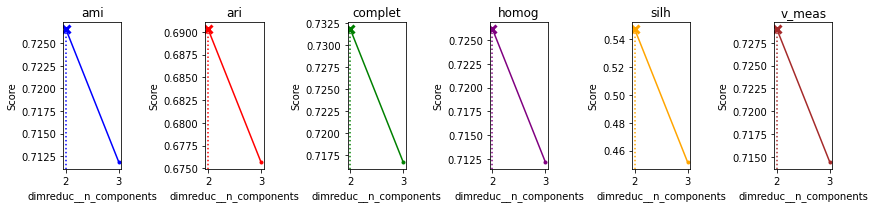

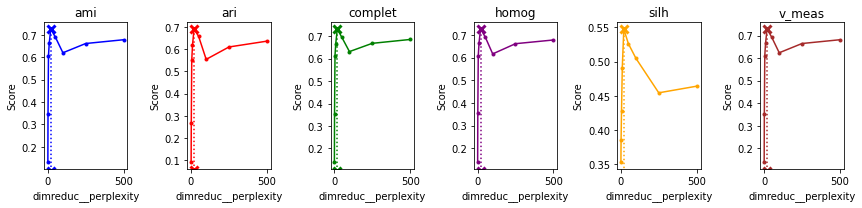

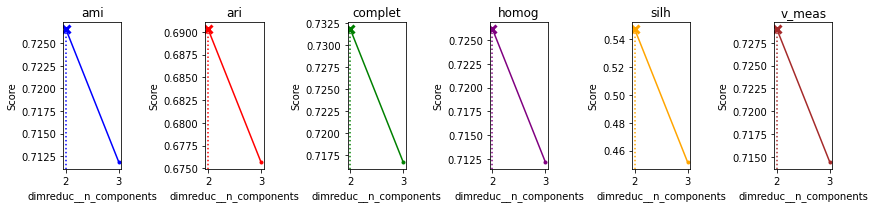

In [128]:
# Plotting the graphs of the clustering scores with best refit score (line)

optim_score = 'ari'

plot_gsc_multi_scores(gsc=gsc_pname, param='dimreduc__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'homog', 'v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc_pname, param='dimreduc__perplexity', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

plot_gsc_multi_scores(gsc=gsc_pname, param='dimreduc__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'homog','v_meas', 'silh'],
                      x_log=False, figsize=(12, 3), optim_score=optim_score)

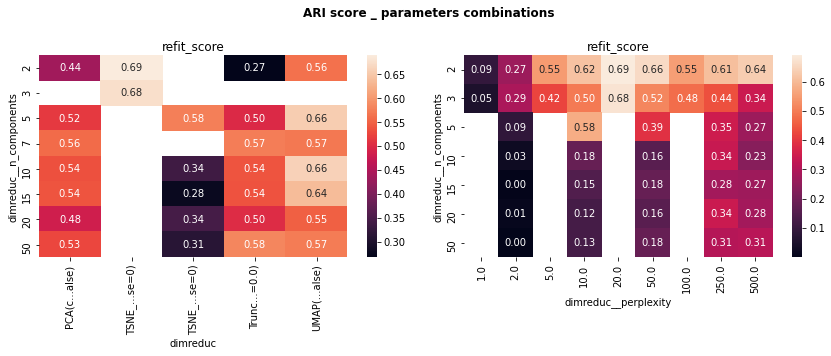

In [129]:
# Effect of 2 parameters on clustering scores

params1 = ['dimreduc__n_components', 'dimreduc']
params2 = ['dimreduc__n_components', 'dimreduc__perplexity']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
plot_2D_gsclust_param_opt(gsc_pname, params=params1, fmt='.2f',
                          shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,2,2)
plot_2D_gsclust_param_opt(gsc_pname, params=params2, fmt='.2f',
                          shorten_label=5, ax=ax2)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

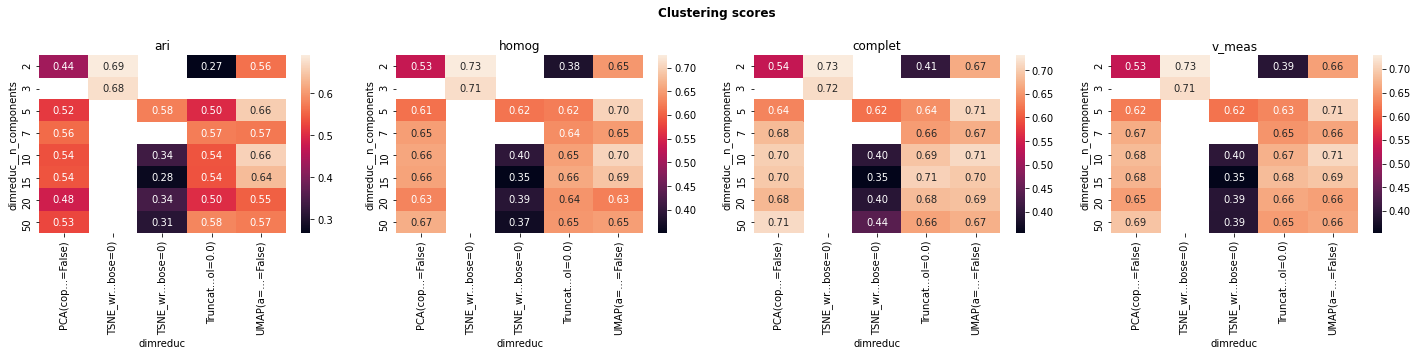

In [130]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(20,5))
params = ['dimreduc__n_components', 'dimreduc']

scores = ['ari', 'homog', 'complet', 'v_meas']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc_pname, params=params, fmt='.2f',
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

Storing the results of the best model

In [ ]:
# Computing the best preprocessed dataset prior to clustering

dict_best_df['N04b_USEpname_dimred_km-ARI'] = \
                gsc_pname.transform(df_USE_pname,
                                    optim_score='ari')
dict_best_df['N04b_USEpname_dimred_km-VMEAS'] = \
                gsc_pname.transform(df_USE_pname,
                                    optim_score='v_meas')

In [ ]:
# Storing labels of the best model in a dataframe

#### A REPARER : POURQUOI GSC.PREDICT NE MARCHE PAS ?
# df_res_clust['N04b_USEpname_dimred_km-ARI'] = \
#                 gsc_pname.predict(df_USE_pname,
#                                   optim_score='ari')
# df_res_clust['N04b_USEpname_dimred_km-VMEAS'] = \
#                 gsc_pname.predict(df_USE_pname,
#                                   optim_score='v_meas')
                
model = gsc_pname._GridSearchClust__get_best_estimator('ari')
df_res_clust['N04b_USEpname_dimred_km-ARI'] = \
                    model.fit_predict(df_USE_pname)
             
model = gsc_pname._GridSearchClust__get_best_estimator('v_meas')
df_res_clust['N04b_USEpname_dimred_km-VMEAS'] = \
                    model.fit_predict(df_USE_pname)

### 4.5 Exportations

In [ ]:
dict_best_df.keys()

dict_keys(['N01_gsc_preproc_km-ARI', 'N01_gsc_preproc_km-VMEAS', 'N02_preproc_dimred_km-ARI', 'N02_preproc_dimred_km-VMEAS', 'N03_gsc_preproc_tm-ARI', 'N03_gsc_preproc_tm-VMEAS', 'N04a_gsc_preproc_dimreduc_w2v_km-ARI', 'N04a_gsc_preproc_dimreduc_w2v_km-VMEAS', 'N04b_USEpname_dimred_km-ARI', 'N04b_USEpname_dimred_km-VMEAS'])

In [ ]:
df_res_clust.columns

Index(['categories', 'N01_gsc_preproc_km-ARI', 'N01_gsc_preproc_km-VMEAS',
       'N02_preproc_dimred_km-ARI', 'N02_preproc_dimred_km-VMEAS', 'N03_gsc_preproc_tm-ARI',
       'N03_gsc_preproc_tm-VMEAS', 'N04b_USEpname_dimred_km-ARI', 'N04b_USEpname_dimred_km-VMEAS'],
      dtype='object')

In [ ]:
# ### Pickling the best preprocessed dataset prior to clustering
# import dill as pickle
# # best dataframe prior to clustering
# with open('NLP_dict_best_df.pkl', 'wb') as file:
#     pickle.dump(dict_best_df, file)
# # best labels
# with open('NLP_df_res_clust.pkl', 'wb') as file:
#     pickle.dump(df_res_clust, file)

In [163]:
### Importation
import dill as pickle
with open('NLP_dict_best_df.pkl', 'rb') as file:
    dict_best_df = pickle.load(file)
# best labels
with open('NLP_df_res_clust.pkl', 'rb') as file:
    df_res_clust = pickle.load(file)
with open('df_pict_light.pkl', 'rb') as file:
    df_pict = pickle.load(file)
df_pict = pd.DataFrame(df_pict.values,
                       index = df_res_clust.index,
                       columns=['img_color'])

## 5 Comparison of clusters labels with true categories

#### Matching scores (true categories vs. clusters)

In [151]:
# Comparison of clusters labels with true categories

from sklearn.metrics import adjusted_rand_score, v_measure_score

ser_pairs_ARI = comp_clust_metrics_col_pairs(df_res_clust,
                                                first_vs_others=True,
                                                n_score='ari',
                                                print_opt=True)
ser_pairs_VMEAS = comp_clust_metrics_col_pairs(df_res_clust,
                                                first_vs_others=True,
                                                n_score='v_meas',
                                                print_opt=True)

--- ari between first and the 8 others ---
ari: mean=0.517, std=0.123, min=0.329, max=0.690 
--- v_meas between first and the 8 others ---
v_meas: mean=0.619, std=0.067, min=0.534, max=0.729 


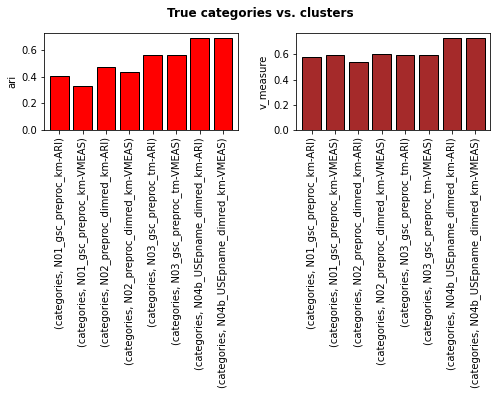

In [133]:
# Plotting the results

fig = plt.figure(figsize=(8,2))

ax1 = fig.add_subplot(121)
ser_pairs_ARI.plot.bar(width=0.8, color='red', ec='k', ax=ax1)
ax1.set_ylabel('ari')
# ax1.set(ylim=(0,1))

ax2 = fig.add_subplot(122)
ser_pairs_VMEAS.plot.bar(width=0.8, color='brown', ec='k', ax=ax2)
ax2.set_ylabel('v_measure')
# ax2.set(ylim=(0,1))

fig.suptitle('True categories vs. clusters',
             fontweight='bold')
fig.subplots_adjust(top=0.8, wspace=0.3)
plt.show()

#### Confusion matrix

In [152]:
cat_clust_confmat = plot_conf_matrix_cat_vs_clust(df_res_clust['categories'],
                                                  df_res_clust['N04b_USEpname_dimred_km-ARI'],
                                                  normalize=False,
                                                  margins_sums=True,
                                                  margins_score=True)
with pd.option_context('display.float_format', '{:.0f}'.format):
    display(cat_clust_confmat)

N04b_USEpname_dimred_km-ARI,5,3,4,0,6,2,1,cat_sum,cat_matching_score_pct
categories,,,,,,,,,
Baby,91,7,1,15,29,7,0,150,61
Beauty,12,121,3,4,1,7,2,150,81
Computers,0,0,149,0,0,0,1,150,99
Decor,0,0,1,121,6,19,3,150,81
Furnishing,0,0,0,5,144,1,0,150,96
Kitchen,0,0,10,30,1,109,0,150,73
Watches,0,0,0,0,0,0,150,150,100
clust_sum,103,128,164,175,181,143,156,-,-
clust_matching_score_pct,88,95,91,69,80,76,96,-,-


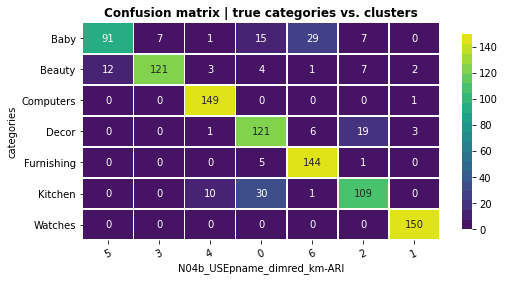

In [135]:
cm = plot_conf_matrix_cat_vs_clust(df_res_clust['categories'],
                            df_res_clust['N04b_USEpname_dimred_km-ARI'],
                            normalize=False,
                            margins_sums=False,
                            margins_score=False)
plot_heatmap(cm, "Confusion matrix | true categories vs. clusters",
             figsize=(8, 4), vmin=0, vmax=150, center=75,
             palette=sns.color_palette("viridis", 20), shape='rect',
             fmt='.0f', robust=False, fig=None, ax=None)

####  Sankey confusion diagram

In [136]:
# to get interactive graph
plot_sankey_confusion_mat(cm, static=False, font_size=14, palette='tab10')

In [ ]:
# # to get interactive graph
# plot_sankey_confusion_mat(cm, static=False, font_size=14)

# to get static graph static
import plotly.graph_objects as go
from IPython.display import Image

img_bytes = plot_sankey_confusion_mat(cm, static=True, font_size=18,
                                      figsize=(2, 1.7), scale = 1)
Image(img_bytes)

#### 2D visualisation

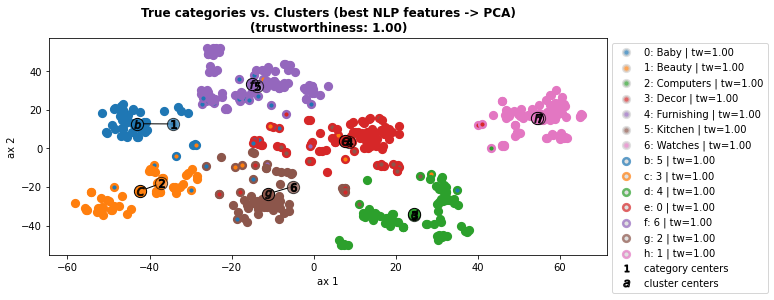

In [139]:
# Plotting a projection of the points (true categories vs. clusters) (PCA 0.71, UMAP 0.81, t-SNE 0.83)

# to plot only a sample of the points
ind_samp = df_res_clust.sample(500, random_state=14).index
data = pd.DataFrame(dict_best_df['N04b_USEpname_dimred_km-ARI'],
                    index=df_res_clust.index)

plot_projection_cat_clust(data.loc[ind_samp],
                          model=None,
                          ser_clust=df_res_clust['N04b_USEpname_dimred_km-ARI'].loc[ind_samp], # clustering already done
                 true_cat=df_res_clust['categories'].loc[ind_samp], # true categories
                 proj='PCA', tw_n_neigh=5, 
                 size=45, edgelinesize=2.5, legend_on=True,
                 title="True categories vs. Clusters (best NLP features -> PCA)",
                 figsize=(10, 4), palette='tab10',
                 fig=None, ax=None, random_state=14, bboxtoanchor=(1,1))

## 5 Analysis of misclassified items

In [153]:
cm

N04b_USEpname_dimred_km-ARI,5,3,4,0,6,2,1
categories,,,,,,,
Baby,91,7,1,15,29,7,0
Beauty,12,121,3,4,1,7,2
Computers,0,0,149,0,0,0,1
Decor,0,0,1,121,6,19,3
Furnishing,0,0,0,5,144,1,0
Kitchen,0,0,10,30,1,109,0
Watches,0,0,0,0,0,0,150


In [165]:
df_res_clust = categ_identificator(df_res_clust)
df_res_clust.sample(3)

,categories,N01_gsc_preproc_km-ARI,N01_gsc_preproc_km-VMEAS,N02_preproc_dimred_km-ARI,N02_preproc_dimred_km-VMEAS,N03_gsc_preproc_tm-ARI,N03_gsc_preproc_tm-VMEAS,N04b_USEpname_dimred_km-ARI,N04b_USEpname_dimred_km-VMEAS
uniq_id,,,,,,,,,
031c98cfde349d99fb6d5983f54c8751,Computers,Computers,Beauty,Beauty,Beauty,Beauty,Beauty,Computers,Computers
a4d9e71172f619f8e3122e34bb0bf3cc,Decor,Decor,Decor,Decor,Decor,Decor,Decor,Decor,Decor
8396537a124f502d11ab99972c816129,Beauty,Computers,Beauty,Kitchen,Computers,Beauty,Beauty,Beauty,Beauty


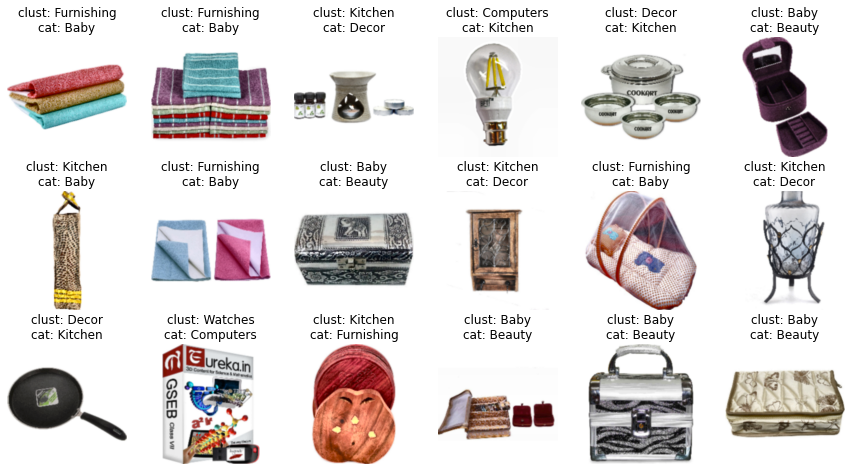

In [166]:
mask = df_res_clust['N04b_USEpname_dimred_km-ARI']!=df_res_clust['categories']
misclass = list(df_desc_cat.loc[mask].index)
wrong_title = df_res_clust['N04b_USEpname_dimred_km-ARI'].loc[misclass]
correct_title = df_res_clust['categories'].loc[misclass]
li_im_title = [f'clust: {w}\ncat: {c}' for w, c in zip(wrong_title, correct_title)]

print_thumbnails_from_df(df_pict['img_color'], misclass[0:18], n_rows=3,
                         figsize=(15,8),
                         li_im_title=li_im_title)

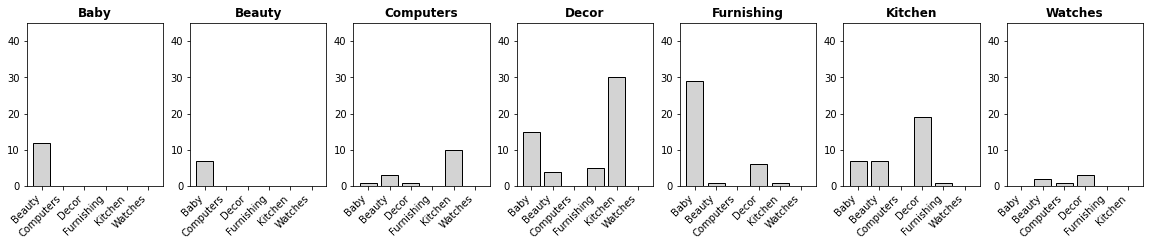

In [168]:
fig = plt.figure(figsize=(20,3))

ser_mis = []
for i, categ in enumerate(cm.index, 1):
    ax = fig.add_subplot(1,7,i)
    mask = [True if x != i else False for x in range(1,8)]
    temp = list(cm.index)
    temp.remove(categ)
    li_misclass = cm.loc[mask].iloc[:,(i-1)]
    ser_mis.append((categ, sum(li_misclass)))
    plt.bar(temp, li_misclass, ec='k', color='lightgrey')
    plt.xticks(rotation=45, ha='right')
    ax.set_title(categ, fontweight='bold')
    ax.set(ylim=(0,45))
ser_mis = pd.Series(dict(ser_mis))

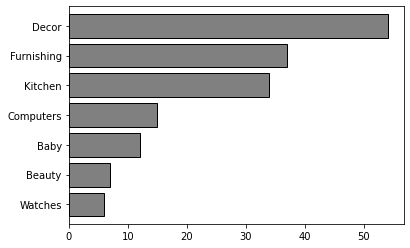

In [170]:
ser_mis.sort_values().plot.barh(width=0.8, ec='k', color='grey')